In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

Лекция посвящена попыткам ответить на следующие вопросы:
- Как проверить критерий - правильно ли он реализован и работает ли он на практике? (в частности, поймём работает ли t-test на маленьких выборках)
- Как из 2х критериев выбрать лучший

Что значит, что критерий корректен?
- Критерий уровня значимости $\alpha$ означает, что вероятность неверно отвергнуть нулевую гипотезу $\leq \alpha$
- Значит если много раз повторять эксперимент, в котором верна нулевая гипотеза, то доля ложноположительных срабатываний будет не больше $\alpha$

По сути, выше мы и описали процедуру проверки   
  
0. Создаём код критерия
1. Генерируем эксперименты, в которых верна H0
2. Прогоняем их через критерий
3. Считаем долю ложнополож срабат и сравниваем её с $\alpha$ 

Проверим, можно ли использовать T-test на выборках из нормального распределениея

In [85]:
def get_bad_cnt(N, sample_dist1, sample_dist2):
    bad_cnt = 0
    N = 1_000
    alpha = 0.05

    sample_dist = stats.norm(loc=5, scale=2)
    mu0=sample_dist.mean()

    for i in tqdm(range(N)):
        test = sample_dist1.rvs(5)
        control = sample_dist2.rvs(5)

        pvalue = stats.ttest_ind(test, control, alternative='two-sided').pvalue

        bad_cnt += (pvalue < alpha)
    return bad_cnt

In [97]:
N = 1_000
sample_dist = stats.norm(loc=5, scale=2)
print(round(get_bad_cnt(N, sample_dist, sample_dist) / N, 3))

100%|██████████| 1000/1000 [00:01<00:00, 536.75it/s]

0.044


Полученное значение является лишь приближением к истинному FPR, лучше построить для него доверительный интервал, чтобы понять в каких пределах может лежать истинное значение

In [57]:
x = np.empty(100)
for i in tqdm(range(100)):
    x[i] = get_bad_cnt(N, sample_dist, sample_dist)

100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


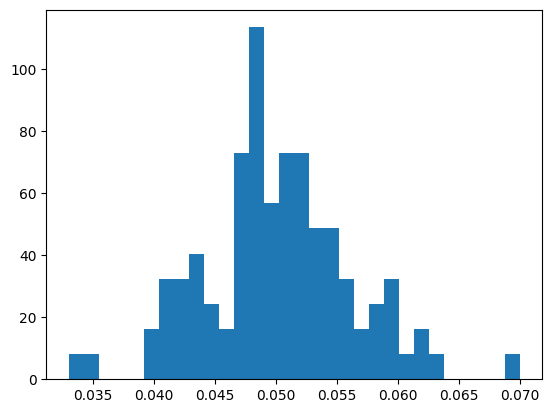

In [58]:
fig, ax = plt.subplots()
ax.hist(x / N, density=True, bins=30);

In [59]:
q1, q2 = np.quantile(x / N, [0.025, 0.975])
print(round(q1, 3), round(q2, 3))

0.04 0.062


Эмпирически сверху построил доверительный интервал, но выборка слишком мала, чтобы быть показательной, а увеличение её размера приведёт к получасовому ожиданию, поэтому можно построить приближённый доверительный интервал Уилсона 

In [98]:
bad_cnt = get_bad_cnt(N, sample_dist, sample_dist)
proportion_confint(count=bad_cnt, nobs=N, alpha=0.05, method='wilson')

100%|██████████| 1000/1000 [00:01<00:00, 688.49it/s]


(0.039000942775266834, 0.06643548634476167)

In [99]:
print(round(bad_cnt / N, 2))

0.05


В любом случае, 0.05 попадает в интервал, поэтому можем считать, что критерий валиден

Посмотрим что будет если выборки для теста и контроля из разных распределений с одинаковым матожем

In [62]:
test_distr = stats.norm(loc=3, scale=3)
control_distr = stats.expon(scale=3)
test_distr.mean() == control_distr.mean()

np.True_

In [63]:
print(round(get_bad_cnt(N, test_distr, control_distr) / N, 3))

100%|██████████| 1000/1000 [00:01<00:00, 630.79it/s]

0.057


In [70]:
x = np.empty(1000)
for i in tqdm(range(1000)):
    x[i] = get_bad_cnt(N, test_distr, control_distr)

100%|██████████| 1000/1000 [25:26<00:00,  1.53s/it]


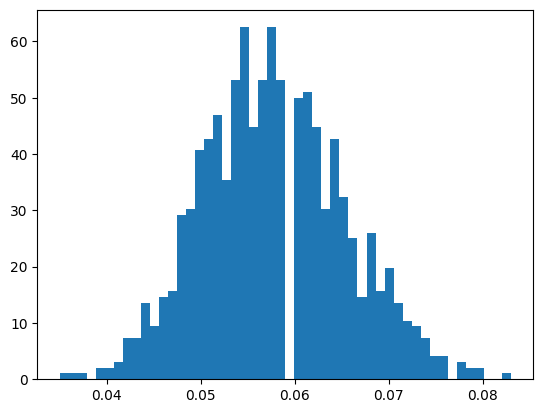

In [76]:
fig, ax = plt.subplots()
ax.hist(x / N, density=True, bins=50);

In [77]:
q1, q2 = np.quantile(x / N, [0.025, 0.975])
print(round(q1, 3), round(q2, 3))

0.044 0.073


In [69]:
bad_cnt = get_bad_cnt(N, test_distr, control_distr)
proportion_confint(count=bad_cnt, nobs=N, alpha=0.05, method='wilson')

100%|██████████| 1000/1000 [00:01<00:00, 707.51it/s]


(0.05043620089822952, 0.08090073250117454)

In [68]:
print(round(bad_cnt / N, 2))

0.06


Доверительный интервал Уилсона показывает, что истинное значение FPR скорее всего больше 0.05

In [103]:
def check_criterion(test_dist, control_dist, sample_size, N_exps=10000, to_print=True):
    """
        Функция для проверки t-test критерия для AB-теста
        Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.
    
        Параметры:
            - test_dist: Распределение тестовой выборки в эксперименте
            - control_dist: Распределение контрольной выборки в эксперименте
            - sample_size: размер выборки теста и контроля
            - N_exps: число экспериментов, по которым потом считается FPR
            - to_print: печатать результат или нет. Если нет, то функция возвращает дов. интервал для FPR.
    """
    
    bad_cnt=0
    alpha=0.05

    for i in tqdm(range(N_exps)):
        # Генерирую выборку
        test    = test_dist.rvs(sample_size)
        control = control_dist.rvs(sample_size)

        # Запускаю критерий и считаю p-value
        pvalue = stats.ttest_ind(test, control, equal_var=False, alternative='two-sided').pvalue

        # Проверяю, что pvalue < alpha
        bad_cnt += (pvalue < alpha)

    if to_print:
        print(f"FPR: {round(bad_cnt / N_exps, 4)}")
        print(f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')}")
    else:
        return proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')

Как проверить минимальный размер выборки при котором t-test работает?

Для этого просимулируем эксперимент с разным размером выборок и посмотрим с какого ращмера выборки альфа лежит в дов интервале

In [101]:
alpha = 0.05
scale = np.arange(20, 110, 20)
for N in scale:
    left, right = check_criterion(test_dist=test_distr, control_dist=control_distr, sample_size=N, N_exps=10000, to_print=False)
    if left < alpha < right:
        print(f"Min sample size: {N}")
        break

Min sample size: 20


In [102]:
check_criterion(test_dist=test_distr, control_dist=control_distr, sample_size=20, N_exps=10000)

FPR: 0.0516
CI=(0.047433804428009554, 0.05611056531081321)


In [104]:
check_criterion(test_dist=test_distr, control_dist=control_distr, sample_size=40, N_exps=10000)

100%|██████████| 10000/10000 [00:14<00:00, 667.48it/s]

FPR: 0.0483
CI=(0.04426852864460951, 0.05267837548345972)


In [105]:
check_criterion(test_dist=test_distr, control_dist=control_distr, sample_size=40, N_exps=100000)

100%|██████████| 100000/100000 [02:23<00:00, 697.26it/s]

FPR: 0.0521
CI=(0.05071013778163892, 0.05346427498939972)


Это проверка на искуственных данных, которая не всегда хорошо оотображает реальное состояние дел, поэтому проводятся ещё и АА-тесты

Суть: исторические данные разбиваются на множество датасетов(как правило, 1000 достаточно; разбивать можно по категории товаров, региону, месяцу и тд), каждый из датасетов бьётся случайным образом на две группы, и на них уже проводим  наш тест и замеряем его качество

Чтобы выбрать лучший, из 2х критериев, можно точно так же с помощью метода Монте-Карло оценить мощность критеия - либо искусственно генерим данные, либо на исторических, одну группу в которых немного изменяем